## Importing Relevant Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

## Loading and Transforming the Data

In [2]:
raw_csv_data = pd.read_csv('data/Index2018.csv')
df_comp = raw_csv_data
df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
df_comp.set_index('date', inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method = 'ffill')

## Removing Surplus Data

In [3]:
df_comp['market_value'] = df_comp.spx

In [4]:
del df_comp['spx']
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
size = int(len(df_comp) * 0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## White Noise

In [5]:
# Generate White Noise Series
# np.random.normal creates an array of random values
# from a normal distribution. If we want this sequence
# to be comparable to the S&P one, we need to set its mean
# and standard deviation to that of the actual set.
#
# loc = takes point for the average point of the distribution = mean() of original sequence
# scale = indicates how wide the distribution is = std() of original sequence
wn = np.random.normal(
    loc = df.market_value.mean(), 
    scale = df.market_value.std(),
    size = len(df)
)

In [6]:
# Now add the White Noise to the dataframe
df['wn'] = wn

/Users/paulot/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
# Notice how the mean of the two columns
# is similar, but not entirely equal.
# The reason is that the white noise we generated
# are normally distributed around the mean of the S&P
# However, since each one is generated individually,
# the average does not have to end up being the same
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1091.143541
std,292.559287,292.733408
min,438.920000,106.289118
25%,914.620000,895.873473
50%,1144.650000,1092.578520
75%,1316.280729,1282.894725
max,1570.252238,2253.699113


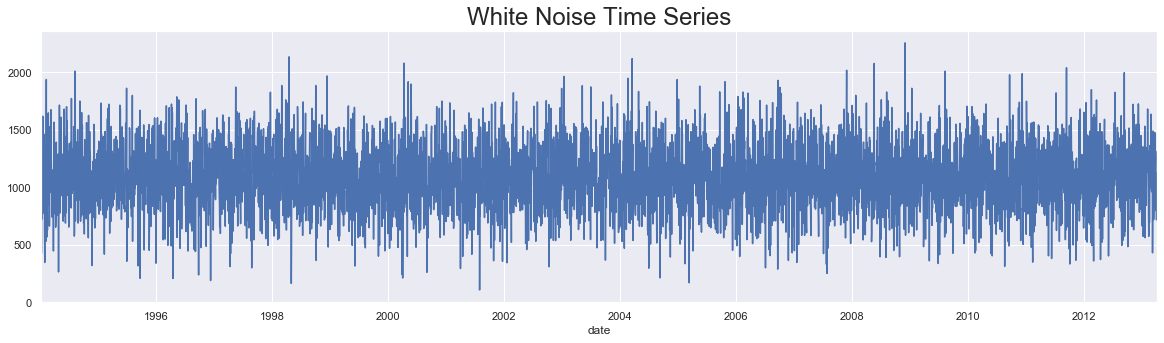

In [8]:
df.wn.plot(figsize = (20, 5))
plt.title('White Noise Time Series', size = 24)
plt.show()

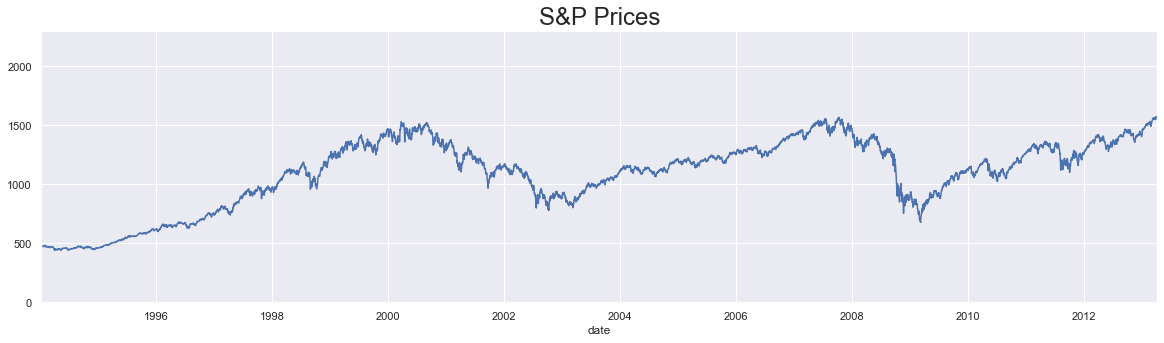

In [9]:
df.market_value.plot(figsize = (20, 5))
plt.title('S&P Prices', size = 24)
plt.ylim(0, 2300)
plt.show()

## Random Walk

In [10]:
rw = pd.read_csv('data/Randwalk.csv')
rw.date = pd.to_datetime(rw.date, dayfirst = True)
rw.set_index('date', inplace = True)
rw = rw.asfreq('b')

In [11]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [12]:
df['rw'] = rw.price

/Users/paulot/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,788.932718,1122.139662
1994-01-10,475.27,423.655481,1080.347860
1994-01-11,474.13,1011.853651,1082.095245
1994-01-12,474.17,820.997899,1083.639265
1994-01-13,472.47,723.221846,1067.146255


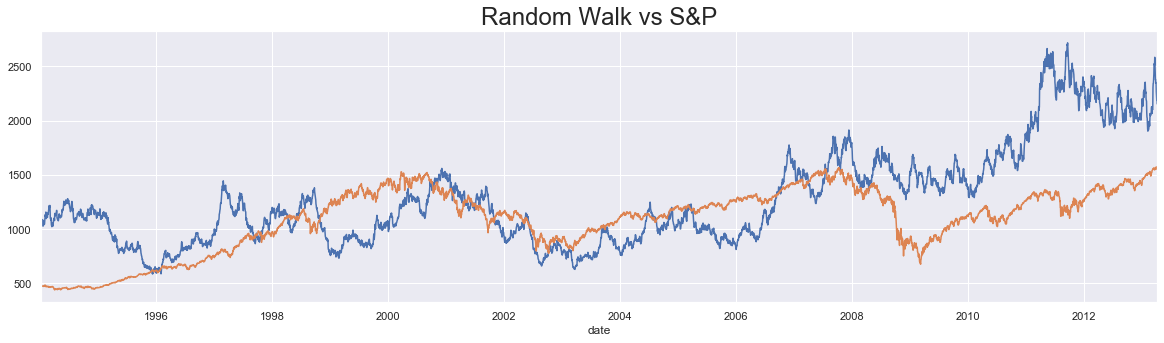

In [14]:
df.rw.plot(figsize = (20, 5))
df.market_value.plot()
plt.title('Random Walk vs S&P', size = 24)
plt.show()
# Notice both datasets contain small variations between consecutive
# time periods. Both contain cyclical increases and decreases in short
# periods of time.

## Stationarity

In [15]:
sts.adfuller(df.market_value)
# First line: Test statistic from running the test
# We can compare it to certain critical values
# to determine whether we have significant proof
# of stationarity

# Second line: We have roughly 41% change of NOT rejecting the null

# Third line: Represents the number of lags used in the regression
# when determining the T Statistic.

# Fourth line: Expresses the number of observations used in the analysis

# Python also provides the 1, 5 and 10% critical values
# from the Dickey-Fuller table.

(-1.7369847452352423,
 0.41216456967706283,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

In [16]:
sts.adfuller(df.wn)

(-72.75821309099356,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 70786.79057956644)

In [17]:
sts.adfuller(df.rw)

(-1.3286073927689703,
 0.6159849181617391,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

## Seasonality

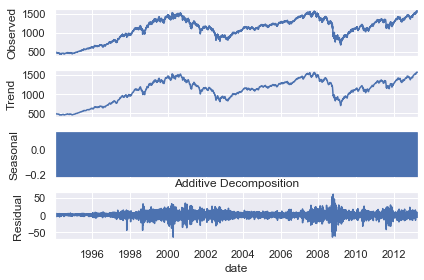

In [18]:
# Decompose the sequence
# We split into 3 effects:
# Trend -> Pattern consisted throughout the data
# Seasonal -> All cyclical effects due to seasonality
# Residual -> Error of prediction

# The simplest type of decomposition is called "Naive".
# With Naive Decomposition we expect a linear relationship
# between the three parts in the observed time series.

# Two main approaches:
# - Additive: Trend + Seasonal + Residual
s_dec_additive = seasonal_decompose(df.market_value, model = 'additive')
s_dec_additive.plot()
plt.title('Additive Decomposition')
plt.show()
# In this case, the result of the additive decomposition
# suggests no seasonality in the data

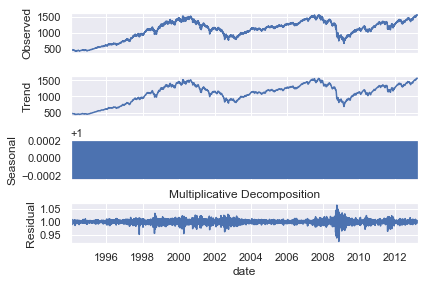

In [19]:
# - Multiplicative: Trend * Seasonal * Residual
s_dec_additive = seasonal_decompose(df.market_value, model = 'multiplicative')
s_dec_additive.plot()
plt.title('Multiplicative Decomposition')
plt.show()
# In this case, the result of the multiplicative decomposition
# suggests no seasonality in the data. Thus, we can safely
# assume there is no seasonality among S&P prices

## The Autocorrelation Function (ACF)

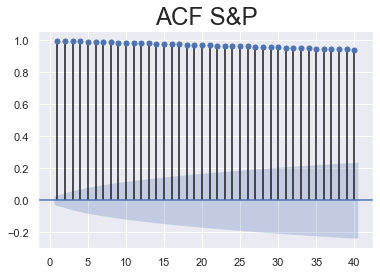

In [20]:
sgt.plot_acf(df.market_value, lags = 40, zero = False)
plt.title('ACF S&P', size = 24)
plt.show()

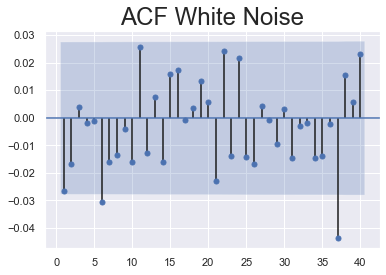

In [21]:
sgt.plot_acf(df.wn, lags = 40, zero = False)
plt.title('ACF White Noise', size = 24)
plt.show()

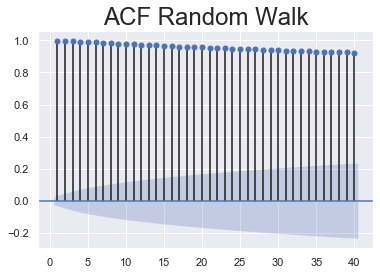

In [22]:
sgt.plot_acf(df.rw, lags = 40, zero = False)
plt.title('ACF Random Walk', size = 24)
plt.show()